<a href="https://colab.research.google.com/github/shobhitsundriyal/f_challenges/blob/master/K_Pubg_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json     

In [2]:
! kaggle competitions download -c pubg-finish-placement-prediction

 94% 16.0M/17.0M [00:00<00:00, 39.8MB/s]
100% 17.0M/17.0M [00:00<00:00, 56.5MB/s]
 95% 231M/244M [00:01<00:00, 154MB/s]
100% 244M/244M [00:01<00:00, 134MB/s]
 86% 86.0M/100M [00:00<00:00, 126MB/s]
100% 100M/100M [00:00<00:00, 153MB/s] 


In [3]:
! unzip \*.zip

Archive:  sample_submission_V2.csv.zip
  inflating: sample_submission_V2.csv  

Archive:  test_V2.csv.zip
  inflating: test_V2.csv             

Archive:  train_V2.csv.zip
  inflating: train_V2.csv            

3 archives were successfully processed.


#### Libraries

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import itertools
import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


#### Loading the data

In [5]:
# Memory saving function credit to https://www.kaggle.com/gemartin/load-data-reduce-memory-usage
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.
    """
    start_mem = df.memory_usage().sum() / 1024**2
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                #if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                #    df[col] = df[col].astype(np.float16)
                #el
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        #else:
            #df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB --> {:.2f} MB (Decreased by {:.1f}%)'.format(
        start_mem, end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [6]:
train = pd.read_csv('/content/train_V2.csv')
train = reduce_mem_usage(train)
test = pd.read_csv('/content/test_V2.csv')
test = reduce_mem_usage(test)

Memory usage of dataframe is 983.90 MB --> 339.28 MB (Decreased by 65.5%)
Memory usage of dataframe is 413.18 MB --> 140.19 MB (Decreased by 66.1%)


In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4446966 entries, 0 to 4446965
Data columns (total 29 columns):
 #   Column           Dtype  
---  ------           -----  
 0   Id               object 
 1   groupId          object 
 2   matchId          object 
 3   assists          int8   
 4   boosts           int8   
 5   damageDealt      float32
 6   DBNOs            int8   
 7   headshotKills    int8   
 8   heals            int8   
 9   killPlace        int8   
 10  killPoints       int16  
 11  kills            int8   
 12  killStreaks      int8   
 13  longestKill      float32
 14  matchDuration    int16  
 15  matchType        object 
 16  maxPlace         int8   
 17  numGroups        int8   
 18  rankPoints       int16  
 19  revives          int8   
 20  rideDistance     float32
 21  roadKills        int8   
 22  swimDistance     float32
 23  teamKills        int8   
 24  vehicleDestroys  int8   
 25  walkDistance     float32
 26  weaponsAcquired  int16  
 27  winPoints   

In [8]:
train.head()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
0,7f96b2f878858a,4d4b580de459be,a10357fd1a4a91,0,0,0.000000,0,0,0,60,1241,0,0,0.000000,1306,squad-fpp,28,26,-1,0,0.0000,0,0.00,0,0,244.800003,1,1466,0.4444
1,eef90569b9d03c,684d5656442f9e,aeb375fc57110c,0,0,91.470001,0,0,0,57,0,0,0,0.000000,1777,squad-fpp,26,25,1484,0,0.0045,0,11.04,0,0,1434.000000,5,0,0.6400
2,1eaf90ac73de72,6a4a42c3245a74,110163d8bb94ae,1,0,68.000000,0,0,0,47,0,0,0,0.000000,1318,duo,50,47,1491,0,0.0000,0,0.00,0,0,161.800003,2,0,0.7755
3,4616d365dd2853,a930a9c79cd721,f1f1f4ef412d7e,0,0,32.900002,0,0,0,75,0,0,0,0.000000,1436,squad-fpp,31,30,1408,0,0.0000,0,0.00,0,0,202.699997,3,0,0.1667
4,315c96c26c9aac,de04010b3458dd,6dc8ff871e21e6,0,0,100.000000,0,0,0,45,0,1,1,58.529999,1424,solo-fpp,97,95,1560,0,0.0000,0,0.00,0,0,49.750000,2,0,0.1875


#### Data fields
* DBNOs - Number of enemy players knocked.
assists - Number of enemy players this player damaged that were killed by teammates.
* boosts - Number of boost items used.
* damageDealt - Total damage dealt. Note: Self inflicted damage is subtracted.
* headshotKills - Number of enemy players killed with headshots.
* heals - Number of healing items used.
* Id - Player’s Id
* killPlace - Ranking in match of number of enemy players killed.
* killPoints - Kills-based external ranking of player. (Think of this as an Elo ranking where only kills matter.) If there is a value other than -1 in rankPoints, then any 0 in killPoints should be treated as a “None”.
* killStreaks - Max number of enemy players killed in a short amount of time.
* kills - Number of enemy players killed.
* longestKill - Longest distance between player and player killed at time of death. This may be misleading, as downing a player and driving away may lead to a large longestKill stat.
* matchDuration - Duration of match in seconds.
* matchId - ID to identify match. There are no matches that are in both the training and testing set.
* matchType - String identifying the game mode that the data comes from. The standard modes are “solo”, “duo”, “squad”, “solo-fpp”, “duo-fpp”, and “squad-fpp”; other modes are from events or custom matches.
* rankPoints - Elo-like ranking of player. This ranking is inconsistent and is being deprecated in the API’s next version, so use with caution. Value of -1 takes place of “None”.
* revives - Number of times this player revived teammates.
* rideDistance - Total distance traveled in vehicles measured in meters.
* roadKills - Number of kills while in a vehicle.
* swimDistance - Total distance traveled by swimming measured in meters.
* teamKills - Number of times this player killed a teammate.
* vehicleDestroys - Number of vehicles destroyed.
* walkDistance - Total distance traveled on foot measured in meters.
* weaponsAcquired - Number of weapons picked up.
* winPoints - Win-based external ranking of player. (Think of this as an Elo ranking where only winning matters.) If there is a value other than -1 in rankPoints, then any 0 in winPoints should be treated as a “None”.
* groupId - ID to identify a group within a match. If the same group of players plays in different matches, they will have a different groupId each time.
* numGroups - Number of groups we have data for in the match.
* maxPlace - Worst placement we have data for in the match. This may not match with numGroups, as sometimes the data skips over placements.
* winPlacePerc - The target of prediction. This is a percentile winning placement, where 1 corresponds to 1st place, and 0 corresponds to last place in the match. It is calculated off of maxPlace, not numGroups, so it is possible to have missing chunks in a match.

#### Part 1: EDA

In [9]:
for i in ['Id', 'groupId', 'matchId']:
  print(f'unique [{i}] count: ', train[i].nunique())

unique [Id] count:  4446966
unique [groupId] count:  2026745
unique [matchId] count:  47965


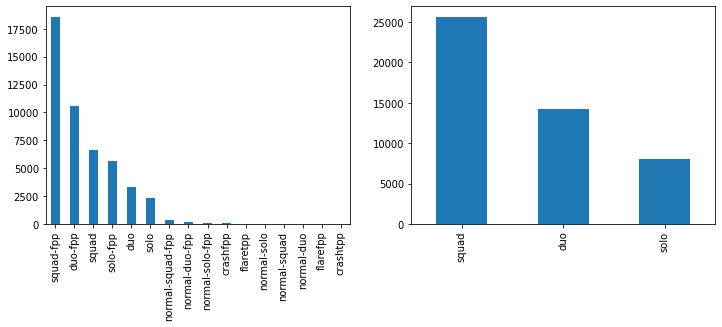

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

train.groupby('matchId')['matchType'].first().value_counts().plot.bar(ax=ax[0])

mapper = lambda x: 'solo' if ('solo' in x) else 'duo' if ('duo' in x) or ('crash' in x) else 'squad'
train['matchType'] = train['matchType'].apply(mapper)
train.groupby('matchId')['matchType'].first().value_counts().plot.bar(ax=ax[1])

##### Player analysis

In [11]:
def mergeList(list1,list2):
    return list(itertools.product(list1,list2))
match = train.groupby(['matchType','matchId']).size().to_frame('players in match')
group = train.groupby(['matchType','matchId','groupId']).size().to_frame('players in group')
pd.concat([match.groupby('matchType').describe()[mergeList(['players in match'],['min','mean','max'])], 
           group.groupby('matchType').describe()[mergeList(['players in group'],['min','mean','max'])]], axis=1)

players in match                   players in group                
                       min       mean    max              min      mean   max
matchType                                                                    
duo                    7.0  92.985658  100.0              1.0  2.050456  72.0
solo                   1.0  89.031872  100.0              1.0  1.039249  64.0
squad                  5.0  93.723193  100.0              1.0  3.492575  74.0

In [12]:
print(group['players in group'].nlargest(5))

matchType  matchId         groupId       
squad      b30f3d87189aa6  14d6b54cdec6bc    74
duo        3e029737889ce9  b8275198faa03b    72
solo       41a634f62f86b7  128b07271aa012    64
duo        7e93ce71ac6f61  7385e5fe214021    49
squad      3c2531adf5b942  e52a2e6ca30474    36
Name: players in group, dtype: int64


##### Check correlation of the feature with Winning Percentage

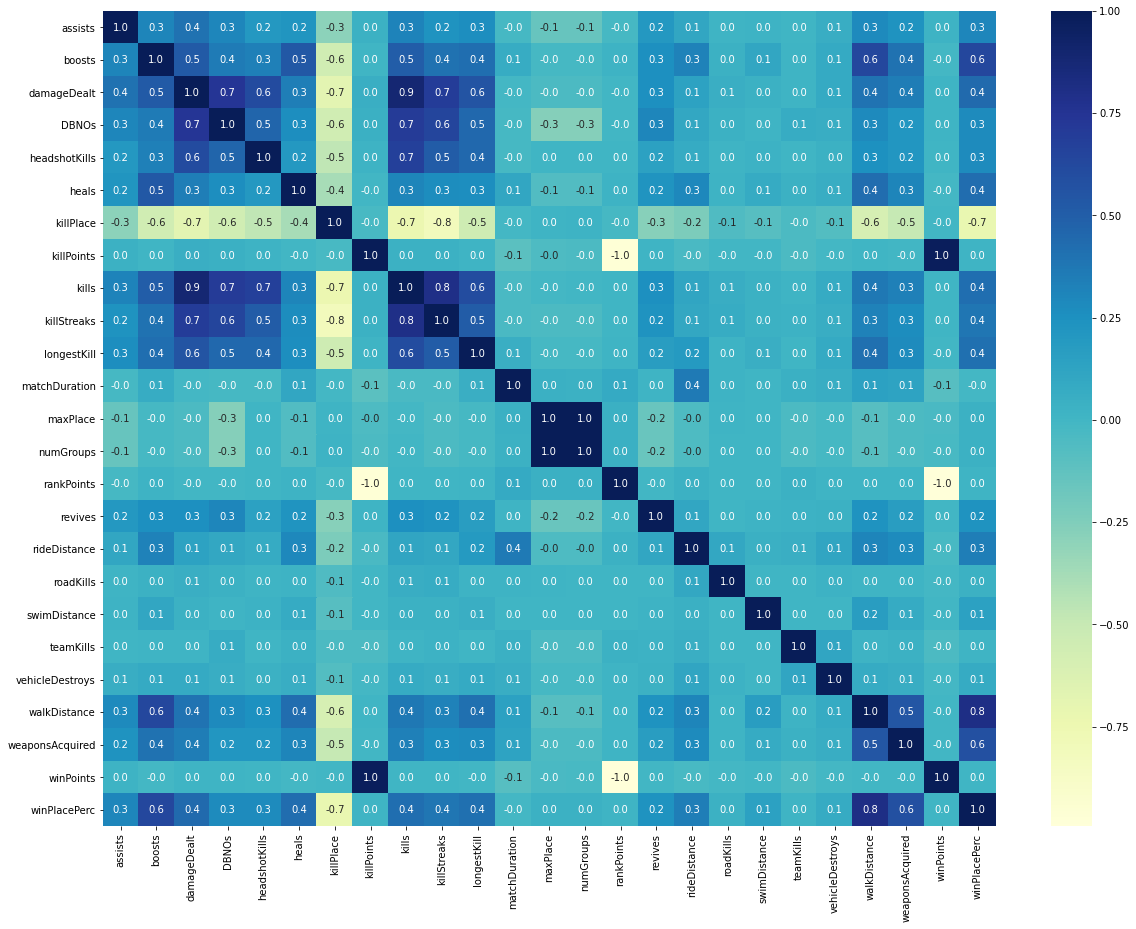

In [13]:
corr = train.corr()
f,ax = plt.subplots(figsize=(20, 15))
sns.heatmap(train.corr(), annot=True, fmt= '.1f',ax=ax, cmap='YlGnBu')
sns.set(font_scale=1.25)
plt.show()

---

#### Part 2: Feature Engineering

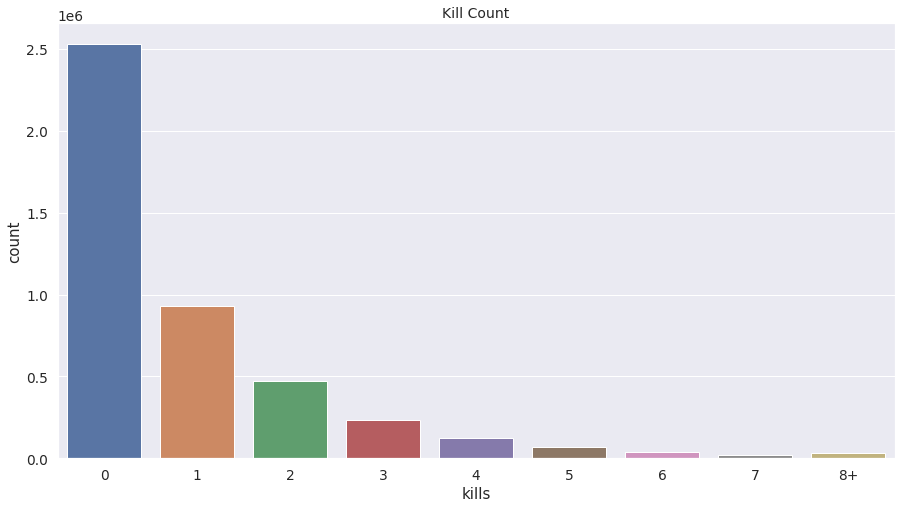

In [14]:
data = train.copy()
data.loc[data['kills'] > data['kills'].quantile(0.99)] = '8+'
plt.figure(figsize=(15,8))
sns.countplot(data['kills'].astype('str').sort_values())
plt.title("Kill Count",fontsize=14)
plt.show()

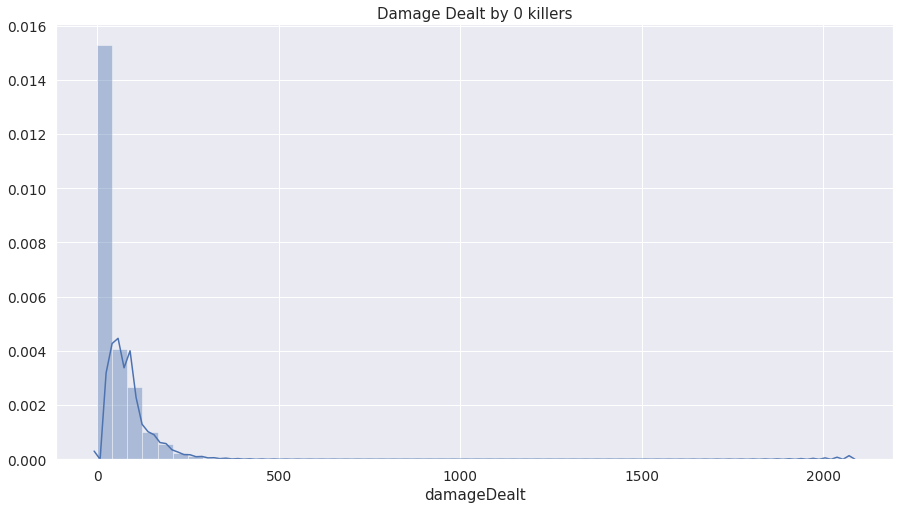

In [15]:
data = train.copy()
data = data[data['kills']==0]
plt.figure(figsize=(15,8))
plt.title("Damage Dealt by 0 killers",fontsize=15)
sns.distplot(data['damageDealt'])
plt.show()

##### Effect of killing on winning percentage

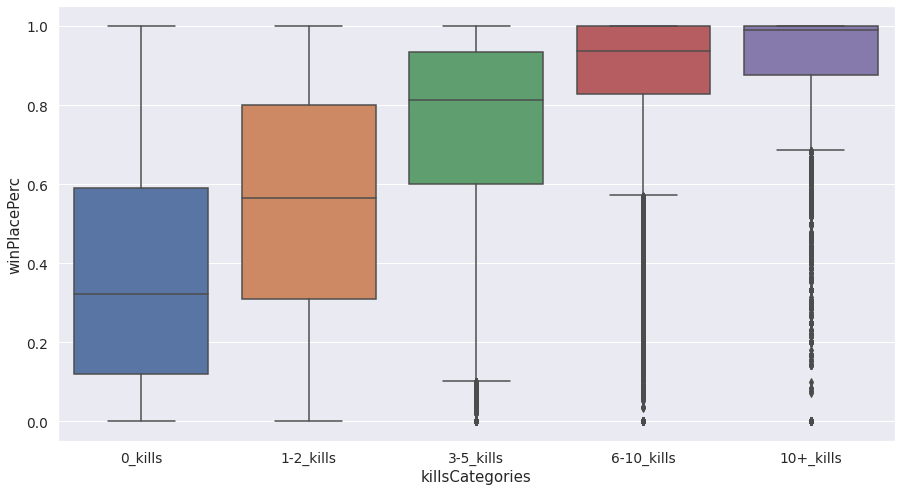

In [16]:
kills = train.copy()

kills['killsCategories'] = pd.cut(kills['kills'], [-1, 0, 2, 5, 10, 60], labels=['0_kills','1-2_kills', '3-5_kills', '6-10_kills', '10+_kills'])

plt.figure(figsize=(15,8))
sns.boxplot(x="killsCategories", y="winPlacePerc", data=kills)

*kills* has a high correlation with *winPlacePerc*.

##### Analyzing walk_distance

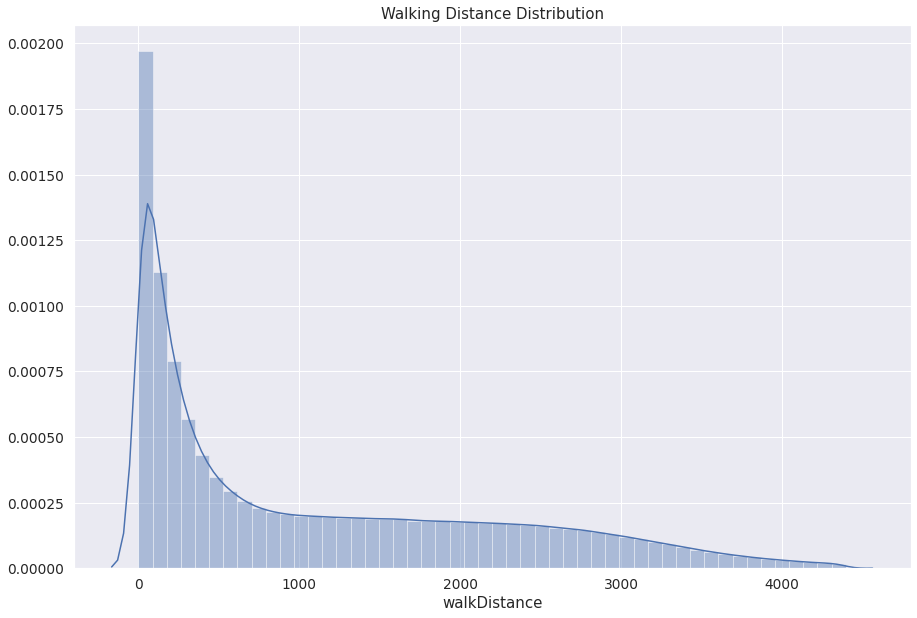

In [17]:
data = train.copy()
data = data[data['walkDistance'] < train['walkDistance'].quantile(0.99)]
plt.figure(figsize=(15,10))
plt.title("Walking Distance Distribution",fontsize=15)
sns.distplot(data['walkDistance'])

##### Effect of Running on Winning Percentage

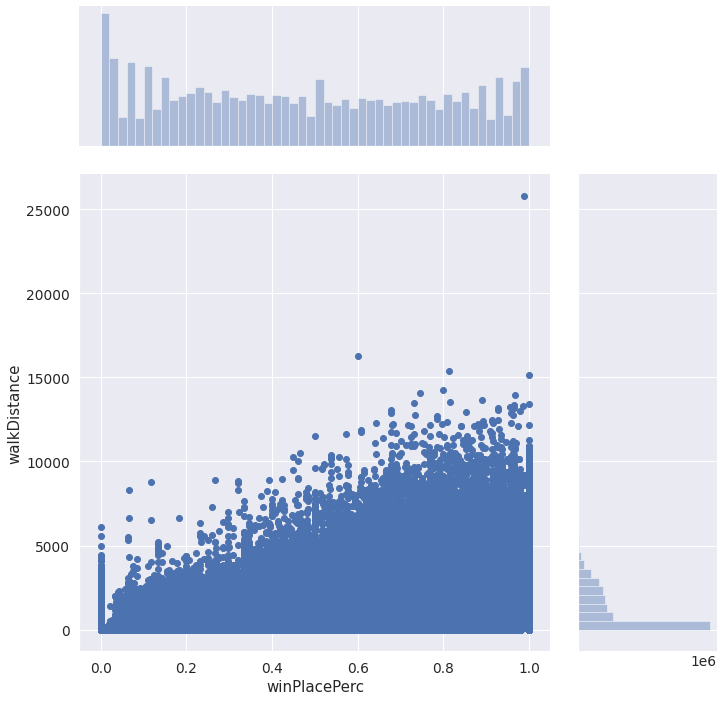

In [19]:
sns.jointplot(x="winPlacePerc", y="walkDistance",  data=train, height=10, ratio=3)

##### Analyzing Riding

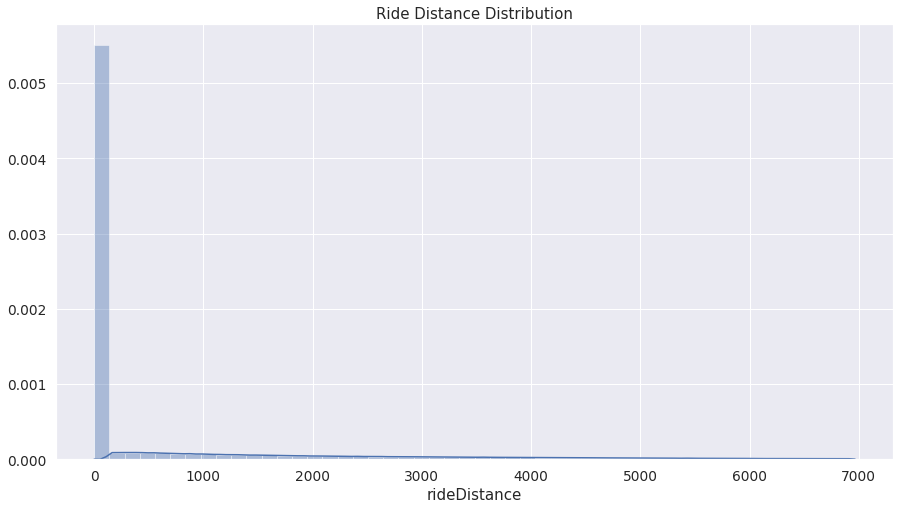

In [20]:
data = train.copy()
data = data[data['rideDistance'] < train['rideDistance'].quantile(0.99)]
plt.figure(figsize=(15,8))
plt.title("Ride Distance Distribution")
sns.distplot(data['rideDistance'])

##### Effect of Riding on Winning Percentage

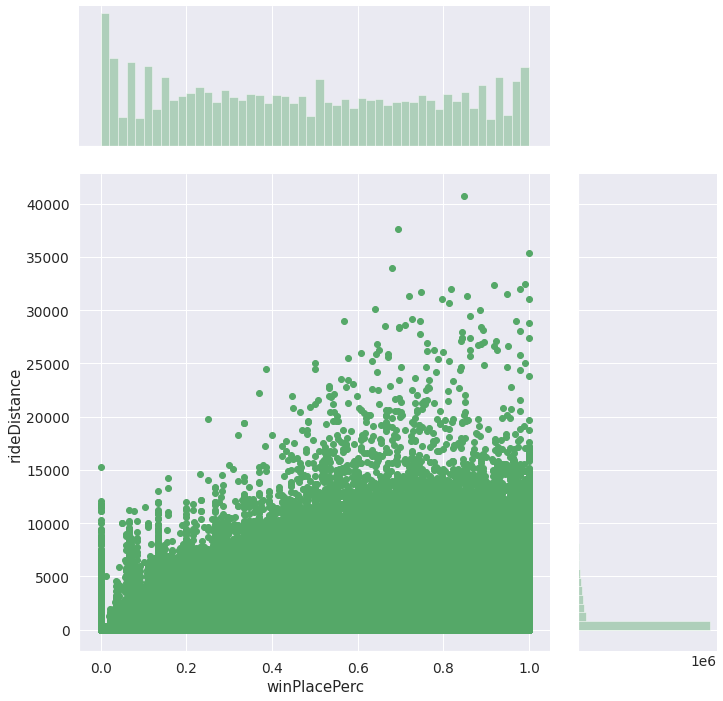

In [22]:
sns.jointplot(x="winPlacePerc", y="rideDistance", data=train, height=10, ratio=3, color="g")

##### Vechicle destruction

Text(0.5, 1.0, 'Vehicle Destroyed/ Win Ratio')

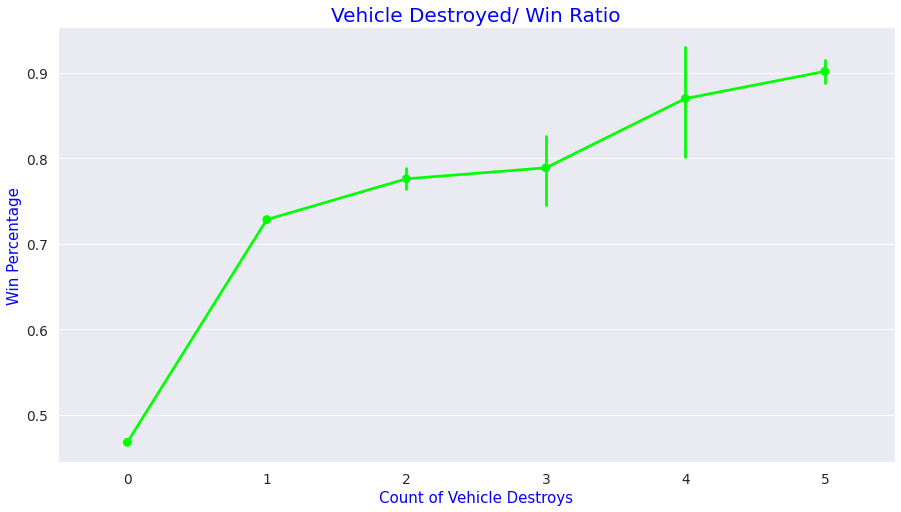

In [23]:
f,ax1 = plt.subplots(figsize =(15,8))
sns.pointplot(x='vehicleDestroys',y='winPlacePerc',data=data,color='lime',alpha=0.5)
plt.xlabel('Count of Vehicle Destroys',color='blue')
plt.ylabel('Win Percentage',color='blue')
plt.title('Vehicle Destroyed/ Win Ratio',fontsize = 20,color='blue')

##### Analyzing Haling and Boosting

In [24]:
print("In the game on an average a person uses {:.1f} heal items, 99% of people use {} or less, while the doctor used {}.".format(train['heals'].mean(), train['heals'].quantile(0.99), train['heals'].max()))
print("In the game on an average a person uses {:.1f} boost items, 99% of people use {} or less, while the doctor used {}.".format(train['boosts'].mean(), train['boosts'].quantile(0.99), train['boosts'].max()))

In the game on an average a person uses 1.4 heal items, 99% of people use 12.0 or less, while the doctor used 80.
In the game on an average a person uses 1.1 boost items, 99% of people use 7.0 or less, while the doctor used 33.


Text(0.5, 1.0, 'Heals vs Boosts')

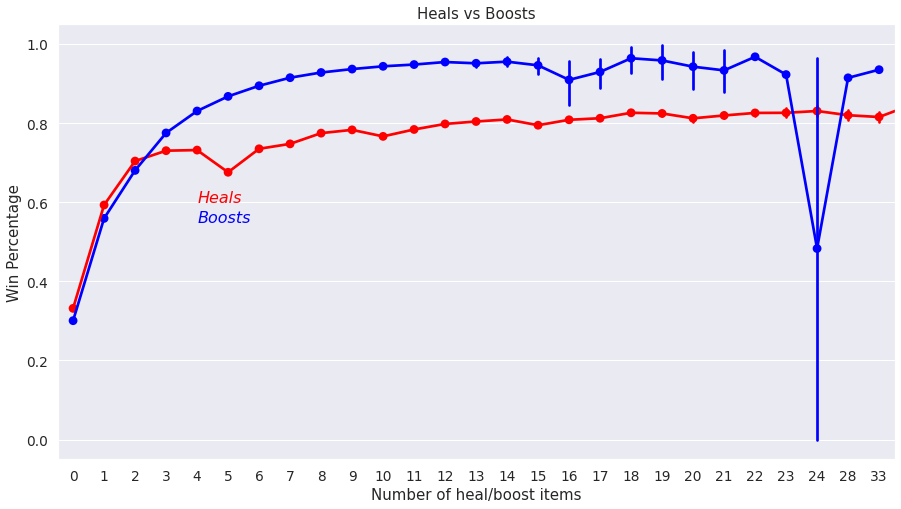

In [25]:
f,ax1 = plt.subplots(figsize =(15,8))
sns.pointplot(x='heals',y='winPlacePerc',data=data,color='red')
sns.pointplot(x='boosts',y='winPlacePerc',data=data,color='blue')
plt.text(4,0.6,'Heals',color='red',fontsize = 16,style = 'italic')
plt.text(4,0.55,'Boosts',color='blue',fontsize = 16,style = 'italic')
plt.xlabel('Number of heal/boost items')
plt.ylabel('Win Percentage')
plt.title('Heals vs Boosts')

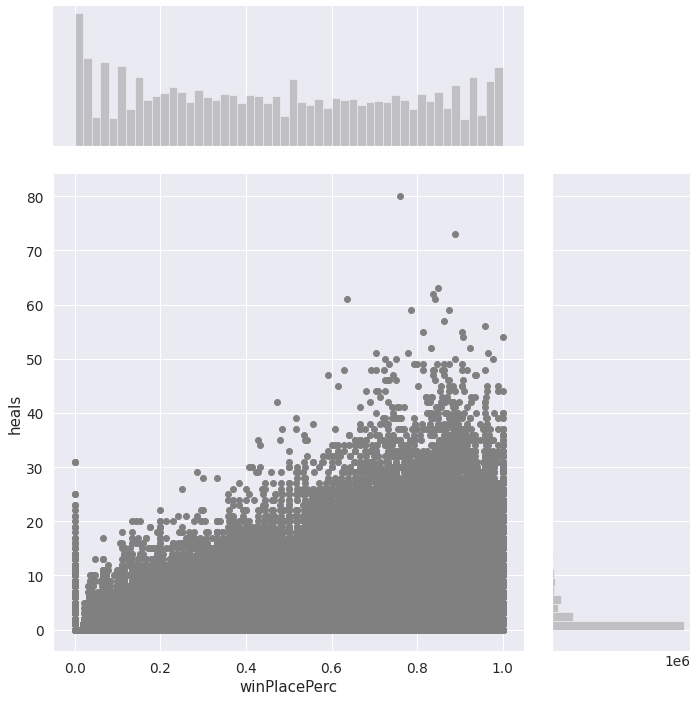

In [26]:
sns.jointplot(x="winPlacePerc", y="heals", data=train, height=10, ratio=3, color="gray")

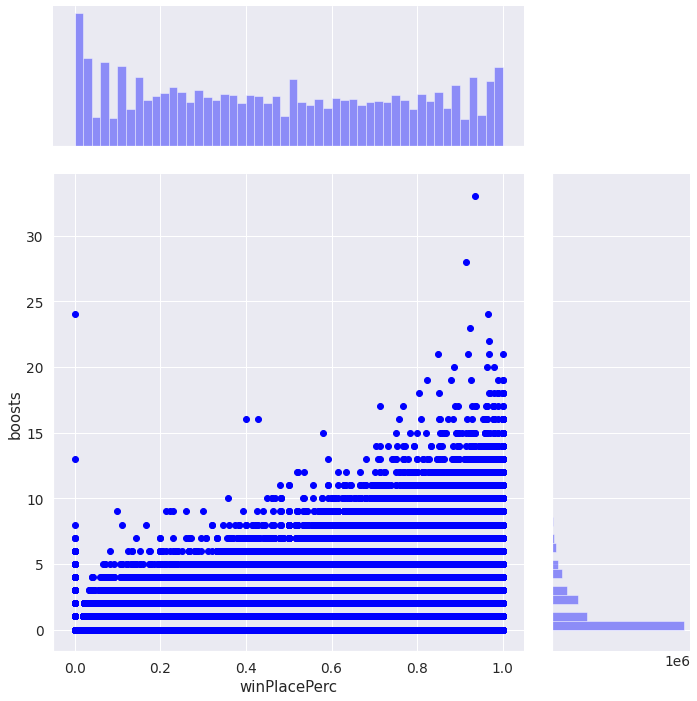

In [27]:
sns.jointplot(x="winPlacePerc", y="boosts", data=train, height=10, ratio=3, color="blue")

##### Effect of Killing in different Game type: Solo, Duos and Squad on Winning Percentage

In [28]:
solos = train[train['numGroups']>50] #Solo game played by more than 50 different groups
duos = train[(train['numGroups']>25) & (train['numGroups']<=50)] #Duo game can consist of a maximum of 50 groups(50x2=100) 
squads = train[train['numGroups']<=25] # Squad game can consist a maximum of 25 groups(25x4=100)
print("{} ({:.2f}%) of games are solo, {} ({:.2f}%) are duo and {} ({:.2f}%) are squad games.".format(len(solos), 100*len(solos)/len(train), len(duos), 100*len(duos)/len(train), len(squads), 100*len(squads)/len(train),))

709111 (15.95%) of games are solo, 3295326 (74.10%) are duo and 442529 (9.95%) are squad games.


Text(0.5, 1.0, 'Solo vs Duo vs Squad Kills')

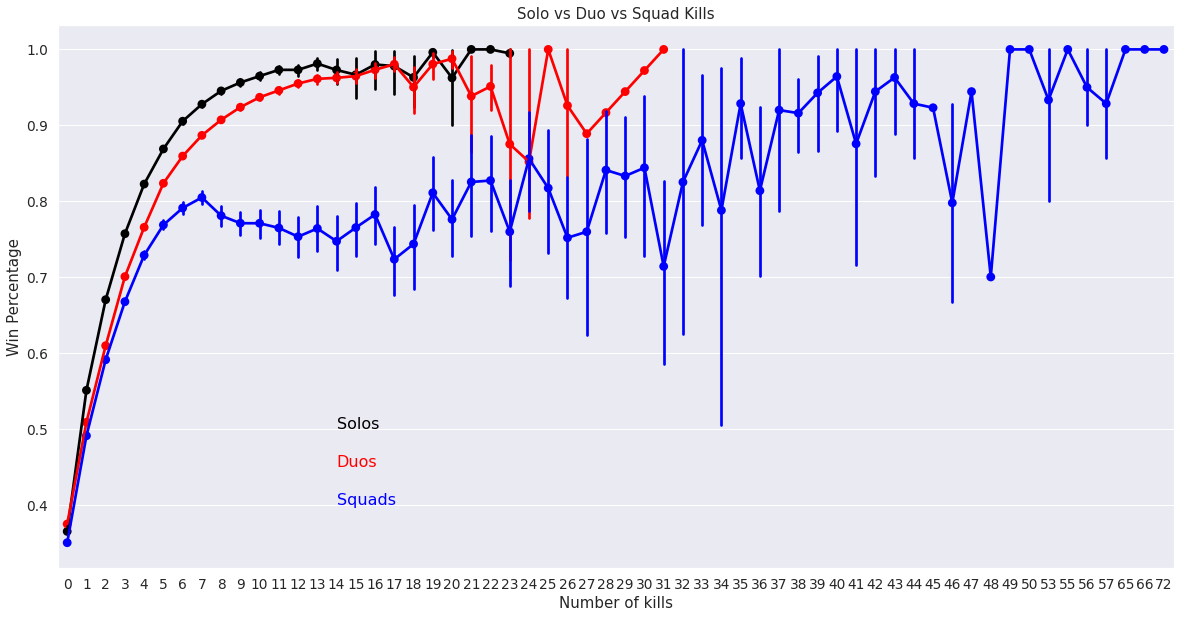

In [29]:
f,ax1 = plt.subplots(figsize =(20,10))
sns.pointplot(x='kills',y='winPlacePerc',data=solos,color='black',alpha=0.6)
sns.pointplot(x='kills',y='winPlacePerc',data=duos,color='red',alpha=0.6)
sns.pointplot(x='kills',y='winPlacePerc',data=squads,color='blue',alpha=0.6)
plt.text(14,0.5,'Solos',color='black',fontsize = 16)
plt.text(14,0.45,'Duos',color='red',fontsize = 16)
plt.text(14,0.4,'Squads',color='blue',fontsize = 16)
plt.xlabel('Number of kills',)
plt.ylabel('Win Percentage',)
plt.title('Solo vs Duo vs Squad Kills')

**Inference:** Solos and duos behave the same, but when playing squads kills don't matter that much.